# Methods to improve accuracy of Viewers' feeling of Youtuber's style Prediction
- Name: **Trần Thanh Dương (SE160185)**
- Class: **AIL302m**

In this notebook, I will try to use some methods to improve the accuracy of the model in previous notebook which are:
1. Neural Network + Polynomial Features
2. Tree Model with NN in every node


# Pre-defining data from previous notebook

In [ ]:
# Import some required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Dataset url
DATASET_URL = "https://gist.githubusercontent.com/duongttr/ff8728ebd7601e67c7d9eca1e86663ce/raw/02b90bb36befb7a7ca95747eaf21309511f796de/Food.csv"

In [ ]:
# Watch how the dataset look like
df = pd.read_csv(DATASET_URL)
df.head(10)

,e,no. video,Student ID,Full name,id,standardized dish,dish occurence (based on transcript),dish imply,start time,end time,...,sauce (based on transcript),venue,container,describe how to make it,viewer feeling of youtuber's style,viewer feeling of presented food,YouTuber feeling,location,foreigner,Unnamed: 24
0,1.0,51.0,NaN,NaN,5OzrpNCyXqs,snail vermicelli soup,bun oc,NaN,1:05,3:21,...,NaN,street restaurant,bowl,1,4,NaN,5,HN,1,NaN
1,2.0,51.0,NaN,NaN,5OzrpNCyXqs,vermicelli with fried tofu and shrimp paste,bun dau mam tom,NaN,3:32,6:10,...,"fish sauce, fermented shrimp paste, pepper, ch...",street restaurant,tray,1,4,NaN,4,HN,1,NaN
2,3.0,51.0,NaN,NaN,5OzrpNCyXqs,fried spring roll,spring roll,NaN,5:23,6:10,...,"fish sauce, sweet spicy garlic sauce",street restaurant,plate,0,5,NaN,5,HN,1,NaN
3,4.0,51.0,NaN,NaN,5OzrpNCyXqs,steamed rolled rice pancake,banh cuon,NaN,6:22,9:23,...,"garlic water, fried caramelized scallion, pepp...",street restaurant,plate,1,5,NaN,5,HN,1,NaN
4,5.0,51.0,NaN,NaN,5OzrpNCyXqs,shrimp cake,shrimp cake,NaN,9:42,11:55,...,"chili, sweet spicy sauce",street restaurant,plate,1,4,NaN,5,HN,1,NaN
5,6.0,51.0,NaN,NaN,5OzrpNCyXqs,boiled snail,snails cooked in lemongrass,ốc bươu hấp sả,12:28,15:17,...,"fish sauce, chili, lime leaves, garlic, lemong...",casual restaurant,bowl,0,5,NaN,5,HN,1,NaN
6,7.0,51.0,NaN,NaN,5OzrpNCyXqs,rolling pho,pho cuon,NaN,15:20,18:25,...,"sweet fish sauce, green papaya",street restaurant,plate,1,5,NaN,5,HN,1,NaN
7,8.0,51.0,NaN,NaN,5OzrpNCyXqs,pho,pho tron,phở gà trộn,19:10,22:33,...,NaN,street restaurant,bowl,1,5,NaN,5,HN,1,NaN
8,9.0,52.0,NaN,NaN,3qfTtx3yG5U,banh mi,banh mi,NaN,2:03,2:18,...,NaN,casual restaurant,bag,1,3,NaN,3,HN,1,NaN
9,10.0,52.0,NaN,NaN,3qfTtx3yG5U,egg coffee,coffee,NaN,2:26,2:52,...,NaN,casual restaurant,glass,0,4,NaN,4,HN,1,NaN


In [ ]:
# Required features for training model
features = ['start time', 'end time', 'Unnamed: 11', 'venue', 'container', 'describe how to make it',
            'viewer feeling of youtuber\'s style ']

In [ ]:
import re

data = df[features].dropna() # Firstly, drop all NaN value in dataset

# Remove all unknown values
data = data[data['start time'].str.contains('start') == False]
data = data[data['start time'].str.contains('Start') == False]
data = data[data['end time'].str.contains('x') == False]
data = data[data['end time'].str.contains('end') == False]
data = data[data['end time'].str.contains('End') == False]
data = data[data['end time'].str.contains('x') == False]

# Rename columns' names
data = data.rename(columns={'Unnamed: 11': 'ingre_count', 'describe how to make it': 'is_described', 
             "viewer feeling of youtuber\'s style ": 'feeling'})

# Convert feeling type
data['feeling'] = data['feeling'].astype(int).replace({0: 1})

# Replace unspecificed values
data['venue'] = data['venue'].replace({'boat restaurant': 'other', 'home': 'other'})
data['container']=data['container'].replace(
              {'hand': 'hands-on', 'no': 'hands-on', 'clay bot': 'pot', 'tray ': 'tray',
              'plastic glass': 'glass', 'Bag': 'bag', 'cup': 'glass'})

data=data[data['is_described'] != '3']
data['is_described']=data['is_described'].astype(int)

# Calculate duration
pattern = '(\d+).*?[;:].*?(\d+)'
def calculate_duration(row):
  import re
  pattern = '(\d+).*?[;:.].*?(\d+)'
  start_time = row[0]
  end_time = row[1]

  try:
    start_min, start_sd = list(map(int, re.findall(pattern, start_time)[0]))
    end_min, end_sd = list(map(int, re.findall(pattern, end_time)[0]))
  except:
    print(row)
    return 0

  return end_min * 60 + end_sd - (start_min *60 + start_sd)

data['duration'] = data.apply(calculate_duration, axis=1)
data = data[data['duration'] > 0]

data=data.drop(labels=['start time', 'end time'], axis=1)

In [ ]:
data['venue']=data['venue'].replace({v: k for k, v in dict(enumerate(data['venue'].unique())).items()})
data['container']=data['container'].replace({v: k for k, v in dict(enumerate(data['container'].unique())).items()})

onehot_venue = pd.get_dummies(data['venue'], 'venue')
onehot_container = pd.get_dummies(data['container'], 'container')

data=data.drop(labels=['venue', 'container'], axis=1)
data=data.join([onehot_venue, onehot_container])

In [ ]:
data.head(10)

,ingre_count,is_described,feeling,duration,venue_0,venue_1,venue_2,venue_3,container_0,container_1,container_2,container_3,container_4,container_5,container_6,container_7,container_8,container_9
0,9,1,4,136,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,11,1,4,158,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,4,0,5,47,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,5,1,5,181,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,4,1,4,133,1,0,0,0,0,0,1,0,0,0,0,0,0,0
5,5,0,5,169,0,1,0,0,1,0,0,0,0,0,0,0,0,0
6,7,1,5,185,1,0,0,0,0,0,1,0,0,0,0,0,0,0
7,17,1,5,203,1,0,0,0,1,0,0,0,0,0,0,0,0,0
8,5,1,3,15,0,1,0,0,0,0,0,1,0,0,0,0,0,0
9,3,0,4,26,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
y = data['feeling']
X = data.drop('feeling', axis=1)

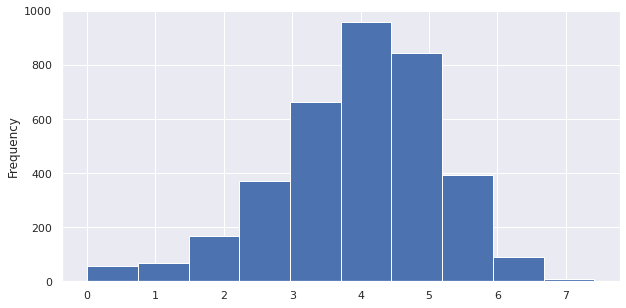

In [ ]:
# Make feature more-likely normal distribution
X['duration'] = np.log(X['duration'] + 1e-8)
X['duration'].plot.hist();

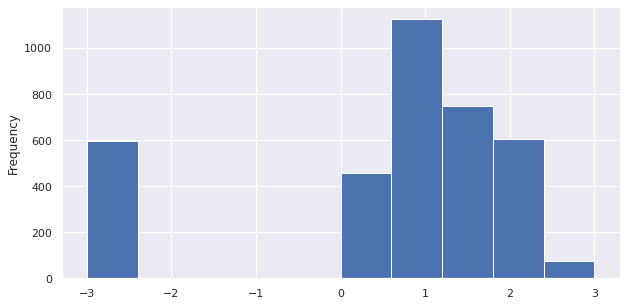

In [ ]:
X['ingre_count'] = np.log(X['ingre_count'] + 0.05)
X['ingre_count'].plot.hist();

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import RandomOverSampler

# Define some models from Scratch

## Neural Network

In [ ]:
from sklearn.utils import shuffle

class Dense:
    def __init__(self, neurons):
        self.neurons = neurons
        
    def relu(self, inputs):
        return np.maximum(0, inputs)

    def softmax(self, inputs):
        exp_scores = np.exp(inputs)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs
    
    def relu_derivative(self, dA, Z):
        dZ = dA.copy()
        dZ[Z <= 0] = 0
        return dZ
    
    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
      if activation == 'softmax': # softmax
          dW = np.dot(A_prev.T, dA_curr)
          db = np.sum(dA_curr, axis=0, keepdims=True)
          dA = np.dot(dA_curr, W_curr) 
      elif activation == 'relu': # relu
          dZ = self.relu_derivative(dA_curr, Z_curr)
          dW = np.dot(A_prev.T, dZ)
          db = np.sum(dZ, axis=0, keepdims=True)
          dA = np.dot(dZ, W_curr)
          
      return dA, dW, db
    
    def forward(self, inputs, weights, bias, activation):
        Z_curr = np.dot(inputs, weights.T) + bias
        
        if activation == 'relu':
            A_curr = self.relu(inputs=Z_curr)
        elif activation == 'softmax':
            A_curr = self.softmax(inputs=Z_curr)
            
        return A_curr, Z_curr

class Network:
    def __init__(self):
        self.network = [] ## layers
        self.architecture = [] ## mapping input neurons --> output neurons
        self.params = [] ## W, b
        self.last_params = [] # lW, lb
        self.memory = [] ## Z, A
        self.gradients = [] ## dW, db
        
    def add(self, layer):
        self.network.append(layer)
            
    def _compile(self, data):
        for idx, layer in enumerate(self.network):
            # apply relu to all layers except the last one
            if idx == 0:
                self.architecture.append({'input_dim':data.shape[1], 'output_dim':self.network[idx].neurons,
                                         'activation':'relu'})
            elif idx > 0 and idx < len(self.network)-1:
                self.architecture.append({'input_dim':self.network[idx-1].neurons, 'output_dim':self.network[idx].neurons,
                                         'activation':'relu'})
            else:
                self.architecture.append({'input_dim':self.network[idx-1].neurons, 'output_dim':self.network[idx].neurons,
                                         'activation':'softmax'})
        return self
    
    def _initialize_weights(self, data):
        self._compile(data)
        
        np.random.seed(99) # random state
        
        for i in range(len(self.architecture)):
            self.params.append({
                'W':np.random.uniform(-1, 1, 
                  size=(self.architecture[i]['output_dim'], 
                        self.architecture[i]['input_dim'])),
                'b':np.zeros((1, self.architecture[i]['output_dim']))})
            
            self.last_params.append({
                'lW':np.zeros((self.architecture[i]['output_dim'], 
                        self.architecture[i]['input_dim'])),
                'lb':np.zeros((1, self.architecture[i]['output_dim']))})
        
        return self
    
    def _forwardprop(self, data):
        A_curr = data
        
        for i in range(len(self.params)):
            A_prev = A_curr
            A_curr, Z_curr = self.network[i].forward(inputs=A_prev, 
                                                     weights=self.params[i]['W'],
                                                     bias=self.params[i]['b'],
                                                     activation=self.architecture[i]['activation'])
            

            self.memory.append({'inputs':A_prev, 'Z':Z_curr})
            
        return A_curr
    
    def predict(self, data):
        A_curr = data
        
        for i in range(len(self.params)):
            A_prev = A_curr
            A_curr, Z_curr = self.network[i].forward(inputs=A_prev, weights=self.params[i]['W'],
                                                     bias=self.params[i]['b'], 
                                                     activation=self.architecture[i]['activation'])
            
        return A_curr
    
    def _backprop(self, predicted, actual):
        num_samples = len(actual)

        ## compute the gradient on predictions
        dscores = predicted
        dscores[range(num_samples),actual] -= 1
        dscores /= num_samples
        
        dA_prev = dscores

        for idx, layer in reversed(list(enumerate(self.network))):
            dA_curr = dA_prev
            
            A_prev = self.memory[idx]['inputs']
            Z_curr = self.memory[idx]['Z']
            W_curr = self.params[idx]['W']
            
            activation = self.architecture[idx]['activation']

            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr, Z_curr, A_prev, activation)

            self.gradients.append({'dW':dW_curr, 'db':db_curr})
            
    def _update(self):
        for idx, layer in enumerate(self.network):

            # momentum here
            new_change_W = self.lr * list(reversed(self.gradients))[idx]['dW'].T + self.momentum * self.last_params[idx]['lW']
            new_change_b = self.lr * list(reversed(self.gradients))[idx]['db'] + self.momentum * self.last_params[idx]['lb']
            self.params[idx]['W'] -= new_change_W
            self.params[idx]['b'] -= new_change_b

            self.last_params[idx]['lW'] = new_change_W
            self.last_params[idx]['lb'] = new_change_b
    
    def _get_accuracy(self, predicted, actual):
        return np.mean(np.argmax(predicted, axis=1)==actual)
    
    def _get_loss(self, predicted, actual):
        samples = len(actual)
        correct_logprobs = -np.log(predicted[range(samples),actual] + 10e-8)
        data_loss = np.sum(correct_logprobs)/samples

        return data_loss
    
    def fit(self, X_train, y_train, 
              validation_data:tuple=None, 
              epochs:int=100, 
              lr:float=0.01, 
              momentum=0.99,
              verbose:bool=True):
        self.lr = lr
        self.momentum = momentum
        self.loss = []
        self.acc = []
        self.val_loss = []
        self.val_acc = []
        
        if validation_data:
          X_valid, y_valid = validation_data
        
        self._initialize_weights(X_train)

        for i in range(epochs):
            shuffle(X_train, y_train)
            yhat = self._forwardprop(X_train)
            self.acc.append(self._get_accuracy(predicted=yhat, actual=y_train))
            self.loss.append(self._get_loss(predicted=yhat, actual=y_train))
            self._backprop(yhat, y_train)
            self._update()
            
            if validation_data:
              valid_yhat = self._forwardprop(X_valid)
              self.val_acc.append(self._get_accuracy(predicted=valid_yhat, actual=y_valid))
              self.val_loss.append(self._get_loss(predicted=valid_yhat, actual=y_valid))
            if verbose and i % 200 == 0:
                s = 'epochs: {} - acc: {:.4f} - loss: {:.4f} - val_acc: {:.4f} - val_loss: {:.4f}'.format(i, self.acc[-1], self.loss[-1], self.val_acc[-1], self.val_loss[-1])
                print(s)
            
            self.memory = []
            self.gradients = []

## Essemble Model with multiple Neural Network nodes


In [ ]:
from typing import List
from sklearn.model_selection import train_test_split

class TreeNNModel:
  def __init__(self, depth_class):
    self.depth_class = depth_class
    self.unique_y = []
    self.nn_network = Network()
    self.nn_network.add(Dense(32))
    self.nn_network.add(Dense(8))
    self.nn_network.add(Dense(len(depth_class)))

    self.nodes = []
    for node in depth_class:
      if isinstance(node, List):
        self.nodes.append(TreeNNModel(node))

  def flatten(self, X):
    if isinstance(X, (tuple, list, set, range)):
      for sub in X:
        yield from self.flatten(sub)
    else:
      yield X
  
  def fit(self, X, Y, lr=0.0001, epochs=5000, momentum=0.9):

    # flatten depth class
    unique_y = set(list(self.flatten(self.depth_class)))
    _y = Y.loc[Y.isin(unique_y)]
    _y_str = _y.astype(str)

    encoder = dict()
    for i, sub in enumerate(self.depth_class):
      for cls in self.flatten(sub):
        encoder[str(cls)] = i

    _y_encoder = _y_str.replace(encoder)

    _X = X.iloc[_y.index]
    print(f'=============TRAINING NODE {str(self.depth_class)}=============')
    X_train, X_test, y_train, y_test = train_test_split(_X, _y_encoder, test_size=0.2, random_state=99, stratify=_y_encoder)

    self.nn_network.fit(X_train.to_numpy(), y_train.to_numpy(),
                        validation_data=(X_test.to_numpy(), y_test.to_numpy()), epochs=epochs, lr=lr, momentum=momentum)

    for node in self.nodes:
      print(node)
      node.fit(X, Y, lr=0.0001, epochs=5000, momentum=0.9)

  def predict(self, X):
    y_pred = np.argmax(self.nn_network.predict(X), axis=1)
    # print(y_pred)
    for i, (id, x) in enumerate(zip(y_pred, X)):
      #print(id, x)
      if isinstance(self.depth_class[int(id)], int):
        yield self.depth_class[int(id)]
        #print(i, self.depth_class, int(id), self.depth_class[int(id)])
      else:
        yield from self.nodes[int(id)].predict([x])

# Methods

In [ ]:
# Splitting data
ros = RandomOverSampler(random_state=99)

pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X_train, X_test, y_train, y_test = train_test_split(pf.fit_transform(X, y), y, random_state=21, test_size=0.2, stratify=y)

y_train = y_train.to_numpy() - np.ones_like(y_train)
y_test = y_test.to_numpy() - np.ones_like(y_test)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## Neural Network + Polynomial Features

In [ ]:
# Initialize model with 3 layers
model = Network()
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(5))

LR = 0.001
EPOCHS = 8000
MOMENTUM = 0.9

model.fit(X_train_resampled, y_train_resampled, 
            validation_data=(X_test, y_test), 
            epochs=EPOCHS, lr=LR, momentum=MOMENTUM)

epochs: 0 - acc: 0.2343 - loss: 11.0096 - val_acc: 0.2618 - val_loss: 10.4174
epochs: 200 - acc: 0.3752 - loss: 1.9732 - val_acc: 0.2825 - val_loss: 2.4558
epochs: 400 - acc: 0.4171 - loss: 1.5159 - val_acc: 0.3116 - val_loss: 2.0070
epochs: 600 - acc: 0.4487 - loss: 1.3626 - val_acc: 0.3130 - val_loss: 1.8347
epochs: 800 - acc: 0.4784 - loss: 1.2834 - val_acc: 0.3144 - val_loss: 1.7535
epochs: 1000 - acc: 0.5034 - loss: 1.2370 - val_acc: 0.3075 - val_loss: 1.7085
epochs: 1200 - acc: 0.5038 - loss: 1.2054 - val_acc: 0.3089 - val_loss: 1.6806
epochs: 1400 - acc: 0.5112 - loss: 1.1807 - val_acc: 0.3075 - val_loss: 1.6634
epochs: 1600 - acc: 0.5196 - loss: 1.1606 - val_acc: 0.3075 - val_loss: 1.6526
epochs: 1800 - acc: 0.5209 - loss: 1.1450 - val_acc: 0.3130 - val_loss: 1.6452
epochs: 2000 - acc: 0.5273 - loss: 1.1319 - val_acc: 0.3144 - val_loss: 1.6405
epochs: 2200 - acc: 0.5289 - loss: 1.1196 - val_acc: 0.3061 - val_loss: 1.6402
epochs: 2400 - acc: 0.5398 - loss: 1.1087 - val_acc: 0.30

Accuracy score: 0.3337950138504155
F1 score: 0.33


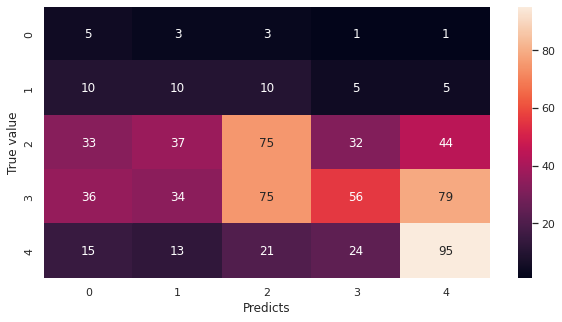

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
y_pred = model.predict(X_test)

print("Accuracy score:", accuracy_score(y_test,np.argmax(y_pred, axis=1)))
print("F1 score: {:.2}".format(f1_score(y_test,np.argmax(y_pred, axis=1), average='micro')))
sns.heatmap(confusion_matrix(y_test, np.argmax(y_pred, axis=1)), annot=True)
plt.xlabel('Predicts')
plt.ylabel('True value')
plt.show()

## Essemble Model with multiple Neural Networks

In [ ]:
tree_nn_model = TreeNNModel([[[1,2],3], 4, 5])

In [ ]:
_, X_test, _, y_test = train_test_split(X, y, random_state=99, test_size=0.2, stratify=y)

In [ ]:
X.index = range(len(X))
y.index = range(len(y))
tree_nn_model.fit(X, y, lr=0.001, epochs=5000)

=============TRAINING NODE [[[1, 2], 3], 4, 5]=============
epochs: 0 - acc: 0.3918 - loss: 1.5028 - val_acc: 0.3920 - val_loss: 1.4566
epochs: 200 - acc: 0.4560 - loss: 1.0415 - val_acc: 0.4806 - val_loss: 1.0339
epochs: 400 - acc: 0.4626 - loss: 1.0271 - val_acc: 0.4792 - val_loss: 1.0220
epochs: 600 - acc: 0.4580 - loss: 1.0205 - val_acc: 0.4861 - val_loss: 1.0168
epochs: 800 - acc: 0.4643 - loss: 1.0164 - val_acc: 0.4820 - val_loss: 1.0132
epochs: 1000 - acc: 0.4632 - loss: 1.0134 - val_acc: 0.4806 - val_loss: 1.0105
epochs: 1200 - acc: 0.4626 - loss: 1.0109 - val_acc: 0.4723 - val_loss: 1.0082
epochs: 1400 - acc: 0.4667 - loss: 1.0088 - val_acc: 0.4820 - val_loss: 1.0062
epochs: 1600 - acc: 0.4726 - loss: 1.0071 - val_acc: 0.4834 - val_loss: 1.0045
epochs: 1800 - acc: 0.4716 - loss: 1.0055 - val_acc: 0.4834 - val_loss: 1.0028
epochs: 2000 - acc: 0.4730 - loss: 1.0039 - val_acc: 0.4945 - val_loss: 1.0012
epochs: 2200 - acc: 0.4726 - loss: 1.0025 - val_acc: 0.4945 - val_loss: 0.9997

In [ ]:
y_pred = list(tree_nn_model.predict(X_test.to_numpy()))

Accuracy score: 0.42105263157894735
F1 score: 0.42


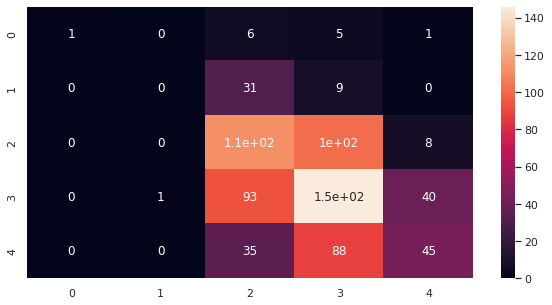

In [ ]:
print("Accuracy score:", accuracy_score(y_test,y_pred))
print("F1 score: {:.2}".format(f1_score(y_test, y_pred, average='micro')))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)